# MSP Italy - Exploratory data analysis

Provide planners and decision makers with an initial and systematic investigation of the geospatial characteristics of the MSP plan. The tool includes features for assessing data quality, detecting inconsistency and for analyzing and visualizing multi-use interactions.

## Table of Contents
* [Pre-processing](#pre-processing)
    * [Loading and cleaning the MSP-Italy plans](#pre-processing_cleaning)
    * [Data validation](#pre-processing_data_validation)
        * [Search for undefined uses](#pre-processing_data_validation_undefined)
        * [Search for invalid geometries](#todo)
* [Planning units profile Report](#todo)
* [MSP areas visualizations and statistics](#todo)
    * [MSP Area surfaces](#todo)
* [MSP sub-areas visualizations and statistics](#todo)
    * [MSP Sub-rea surfaces](#todo)
* [Planning Units (PU) visualizations and statistics](#todo)
    * [MSP Sub-rea surfaces](#todo)
    * [PUs Location (coastal and offshore)](#todo)
    * [PUs type](#todo)
    * [PUs main use](#todo)
* [Multi-use analysis](#todo)
       


# Pre-processing <a class="anchor" id="pre-processing"></a>

In [15]:
# input core packages and util functions
%matplotlib inline

import fiona
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
from upsetplot import from_memberships, plot as upplot, UpSet

from utils import dfuses as _dfuses
import types
from pyproj import Geod
from pandas_profiling import ProfileReport
import contextily as cx
import rioxarray



# add method to GeoDataFrame class
def geodetic_area_perimeter(self):
    crs = self.crs
    _geod = self.crs.get_geod()
    geodetic_crs = self.crs.geodetic_crs
    _geometry = self.geometry.to_crs(geodetic_crs)
    def _a_p(g):
        a_p = _geod.geometry_area_perimeter(g)
        return abs(a_p[0]), abs(a_p[1])
    return pd.DataFrame(_geometry.apply(lambda g: _a_p(g)).to_list(),
                        index=self.index, columns=['geodetic_area', 'geodetic_perimeter'])
setattr(gpd.GeoDataFrame, 'geodetic_area_perimeter', geodetic_area_perimeter)


# annotated stackedbarplot
def add_annotation(ax, suffix=""):
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        txt = ax.text(x+width/2, 
                y+height/2, 
                '{:.0f} {}'.format(height, suffix), 
                horizontalalignment='center', 
                verticalalignment='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        # txt.set_bbox(dict(facecolor='white', 
        #                   # alpha=0.5, 
        #                   edgecolor='white'))
    return ax

## Loading and cleaning the MSP-Italy plans <a class="anchor" id="pre-processing_cleaning"></a>

In [16]:
# Loading geospatial datasets load from the MSP-Italy planning geopackage
source = 'data/planning.gpkg'

AREA_LABELS = {'A': 'Adriatic',
               'IMC': 'Ionian/Central Mediterranean',
              'MO': 'Tyrrenian/Western Mediterranean'}

dfuses = gpd.read_file(source, layer="pu_uses").set_index("code")
code_label_eng = {
    '0100': 'f',
    '0200': 'tm',
    '0300': 'n',
    '0400': 'e',
    '0500': 'sa',
    '0600': 'd',
    '0700': 't',
    '0900': 'tel',
    '1000': 'ppc',
    '1100': 'ds',
    '1200': 'cd',
    '1300': 's',
    '1400': 'r',
    '1500': 'a'
}
dfuses['label_eng'] = dfuses.index.to_series().replace(code_label_eng)

code_use_eng_short = {
    '0100': 'Fishery',
    '0200': 'Maritime transport',
    '0300': 'Environmental protection',
    '0400': 'Energy',
    '0500': 'Sand extrac. & dumping',
    '0600': 'Military defence',
    '0700': 'Tourism',
    '0900': 'Telecommunications',
    '1000': 'Landscape and cult. herit.',
    '1100': 'Dumping sites',
    '1200': 'Coastal defense',
    '1300': 'Maritime safety',
    '1400': 'Research',
    '1500': 'Aquaculture'    
}
dfuses['use_eng_short'] = dfuses.index.to_series().replace(code_use_eng_short)


In [17]:
# cleaning and setup multi-uses representations
msp_areas = gpd.read_file(source, layer="areas")
msp_subareas = gpd.read_file(source, layer="subareas")
msp_subareas.rename(columns={'name': 'location'}, inplace=True)
planning_units = gpd.read_file(source, layer="planning_units")
planning_units['subarea'] = planning_units.Code.str.replace('_\d+', '')
planning_units['msp'] = planning_units.Code.str.replace('/\d+_\d+', '')
# non serve più il merge perche' ora location è presente anche nelle planning units
# planning_units = planning_units.merge(msp_subareas[['subarea','location']], on="subarea")
planning_units['main_uses_sorted_list'] = planning_units.main_uses.str.split(',').apply(lambda x: tuple(sorted([i.strip().zfill(4) for i in x])) if isinstance(x, list) else ())
planning_units['other_uses_sorted_list'] = planning_units.other_uses.str.split(',').apply(lambda x: tuple(sorted([i.strip().zfill(4) for i in x])) if isinstance(x, list) else ())
planning_units['main_uses_sorted_list_labels'] = planning_units.main_uses_sorted_list.apply(lambda x: tuple([dfuses.use_eng_short.get(u, 'undefined') for u in x]))
planning_units['main_uses_sorted_list_codes'] = planning_units.main_uses_sorted_list.apply(lambda x: tuple([dfuses.label_eng.get(u, 'u') for u in x]))

In [18]:
# assign generic typology
_filter = planning_units.main_uses_sorted_list==('0000',)
glabel = 'PUs of Generic typology'
planning_units.loc[_filter, 'main_uses_sorted_list_labels'] = planning_units[_filter].main_uses_sorted_list_labels.apply(lambda x: (glabel,))

In [19]:
# remove invalid geometries (if any)
planning_units = planning_units[planning_units.geometry.is_valid].copy()

In [20]:
# add alternative surface computation
_g_a_p = planning_units.geodetic_area_perimeter()
planning_units['geoarea'] = _g_a_p['geodetic_area'] / 1E6
planning_units['geoperimeter'] = _g_a_p['geodetic_perimeter'] / 1E3
totarea = planning_units.geoarea.sum()
planning_units['geoarea_perc'] = planning_units.geoarea / totarea * 100
# english trnslation
planning_units['location'] = planning_units.location.replace({'acque terr': 'coastal'})

In [21]:
# prepare main_uses DataFrame
data = []
for id, r in planning_units.iterrows():
    if r.main_uses is None:
        continue
    main_uses = r.main_uses.split(',')
    multi = True if len(main_uses)>1 else False
    if r.geometry is None:
        continue
    geoarea_perc = r.geoarea_perc
    location = r.location
    msp = r.msp
    if multi:
        multiarea = geoarea_perc
    else:
        multiarea = 0
    for u in main_uses:
        # print(id, u, int(u))
        # u_label = dfuses.at[int(u), 'label']
        u_label = dfuses.use_eng_short.get(u, {'0000': glabel}.get(u, 'undefined'))
        u_code = dfuses.label_eng.get(u, 'u')
        data.append([u_label, u_code, geoarea_perc, multiarea, location, msp])
df_main_uses = pd.DataFrame(data, columns=['use', 'label_eng', 'geoarea_perc', 'multiarea', 'location', 'msp'])
df_main_uses['singlearea'] = df_main_uses.geoarea_perc - df_main_uses.multiarea

## Data validation <a class="anchor" id="pre-processing_data_validation"></a>

### Search for undefined uses <a class="anchor" id="pre-processing_data_validation_undefined"></a>

In [22]:
planning_units[planning_units.main_uses_sorted_list_labels.apply(lambda x: 'undefined' in x)][['Code', 'main_uses', 'main_uses_sorted_list_labels']]

Empty DataFrame
Columns: [Code, main_uses, main_uses_sorted_list_labels]
Index: []

### Search for invalid geometries <a class="anchor" id=""></a>

In [23]:
planning_units[~planning_units.geometry.is_valid]

Empty GeoDataFrame
Columns: [id, Code, Type, pu_type, lbl_x, lbl_y, pu_types, label, main_uses, other_uses, num_rel, location, area_km, subarea, note, geometry, msp, main_uses_sorted_list, other_uses_sorted_list, main_uses_sorted_list_labels, main_uses_sorted_list_codes, geoarea, geoperimeter, geoarea_perc]
Index: []

[0 rows x 24 columns]

# Planning units profile Report <a class="anchor" id=""></a>

In [25]:
pcolumns = ['Code', 'Type', 'msp', 'subarea', 'pu_type', 'area_km', 'geoarea', 'geoperimeter']
plannin_unit_profile = ProfileReport(planning_units[pcolumns], title="Planning Units Report")
plannin_unit_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# MSP areas visualizations and statistics <a class="anchor" id=""></a>

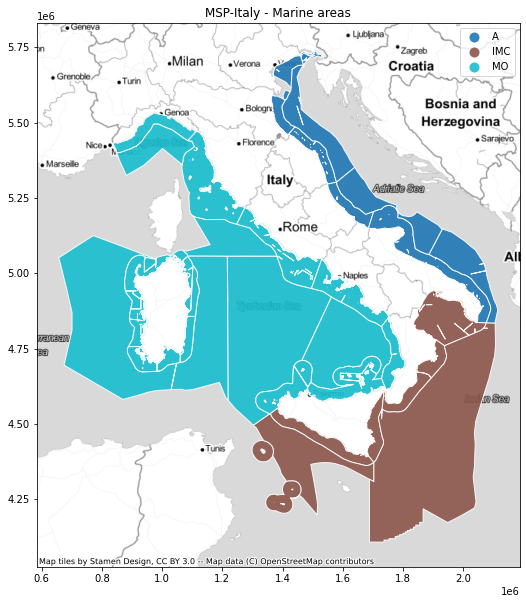

In [24]:
ax = planning_units.dissolve(by='subarea').to_crs(epsg=3857).plot(column="msp", legend=True, 
                                           edgecolor='white',
                                           figsize=[10, 10], alpha=0.9)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_title("MSP-Italy - Marine areas")
plt.savefig("exploratory_outputs/msp_italy_marine_areas.png")
plt.show()

## MSP Area surfaces <a class="anchor" id=""></a>

In [26]:
planning_units.groupby('msp').sum()[['area_km', 'geoarea', 'geoarea_perc']]

area_km        geoarea  geoarea_perc
msp                                        
A     61367.42   61373.191759     11.206256
IMC  176246.75  176260.252505     32.183717
MO   309444.98  310035.593960     56.610028

# MSP sub-areas visualizations and statistics <a class="anchor" id=""></a>

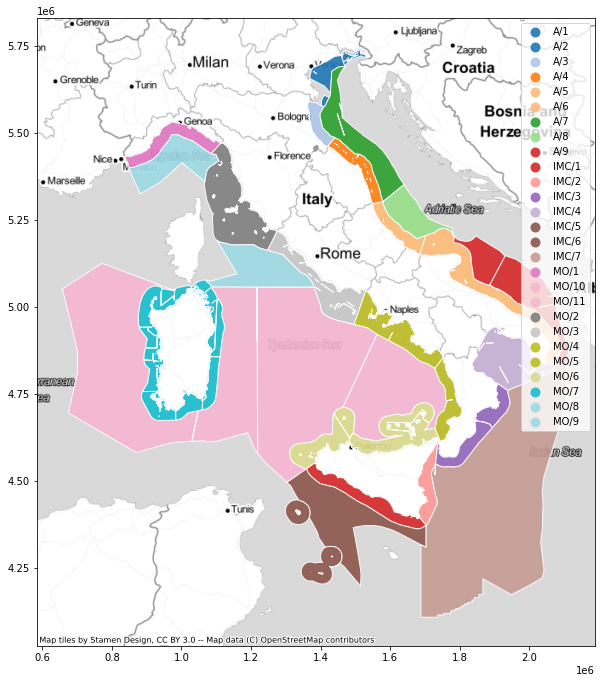

In [27]:
subareas = planning_units.dissolve(by='subarea').reset_index()[['subarea', 'geometry']]
ax = subareas.to_crs(epsg=3857).plot(column="subarea", legend=True, 
                                           edgecolor='white',
                                           figsize=[10, 20], alpha=0.9, cmap="tab20")
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
plt.show()

## MSP Sub-area surfaces <a class="anchor" id=""></a>

In [30]:
planning_units.groupby(['msp', 'subarea']).sum()[['area_km', 'geoarea', 'geoarea_perc']]

area_km        geoarea  geoarea_perc
msp subarea                                        
A   A/1         826.10     826.097070      0.150839
    A/2        2556.84    2556.839001      0.466858
    A/3        2237.65    2237.655302      0.408578
    A/4        3837.07    3837.078525      0.700620
    A/5        3444.24    3444.246743      0.628892
    A/6       12766.76   12772.494012      2.332156
    A/7       11248.19   11248.196458      2.053831
    A/8        6851.67    6851.678030      1.251062
    A/9       17598.90   17598.906619      3.213420
IMC IMC/1      7791.96    7791.966123      1.422751
    IMC/2      4596.66    4596.666398      0.839315
    IMC/3      7492.23    7492.229586      1.368021
    IMC/4     13921.09   13923.112043      2.542249
    IMC/5      7242.93    7254.392103      1.324594
    IMC/6     23813.49   23813.499496      4.348155
    IMC/7    111388.39  111388.386755     20.338631
MO  MO/1       5454.47    5454.475348      0.995944
    MO/10    101770.54  101770.541891     18.582490
    MO/11     96589.38   96589.383869     17.636451
    MO/2      16215.23   16723.271425      3.053536
    MO/3      10617.38   10625.591347      1.940148
    MO/4       9118.54    9118.520979      1.664969
    MO/5       4817.39    4817.391467      0.879617
    MO/6      19169.29   19242.179338      3.513469
    MO/7      22633.38   22634.855591      4.132944
    MO/8       9942.00    9941.998033      1.815330
    MO/9      13117.38   13117.384672      2.395130

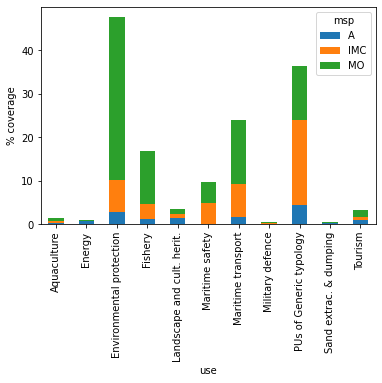

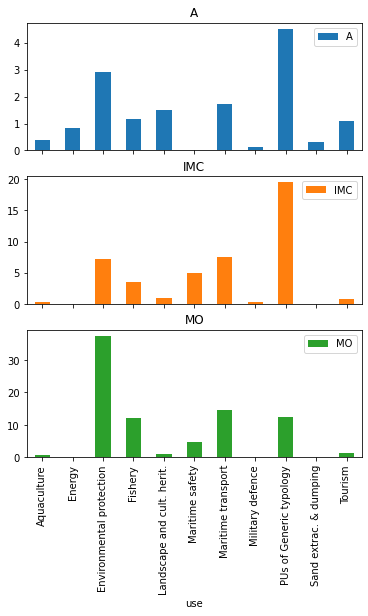

In [31]:
_df = df_main_uses.groupby(['use', 'msp']).sum()
_df = _df.reset_index().pivot(index='use', values='geoarea_perc', columns='msp')
ax = _df.plot.bar(stacked=True,
             # color={"offshore": "navy", "costiera": "cornflowerblue"}
            )
ax.set_ylabel('% coverage')
plt.show()
_df.plot.bar(subplots=True, figsize=[6, 8])
# ax.set_ylabel('% coverage')
plt.show()

# Planning Units (PU) visualizations and statistics <a class="anchor" id=""></a>

## PUs Location (coastal and offshore) <a class="anchor" id=""></a>

In [32]:
pu_agg = planning_units.groupby(['msp','location'])\
.agg(
    PUs=pd.NamedAgg(column="Code", aggfunc="count"),
    kmq=pd.NamedAgg(column="area_km", aggfunc="sum"),
    geoarea=pd.NamedAgg(column="geoarea", aggfunc="sum"),
    geoarea_perc=pd.NamedAgg(column="geoarea_perc", aggfunc="sum"),
    maxarea=pd.NamedAgg(column="geoarea", aggfunc="max"),
    minarea=pd.NamedAgg(column="geoarea", aggfunc="min"),
)
# pu_agg.to_html()

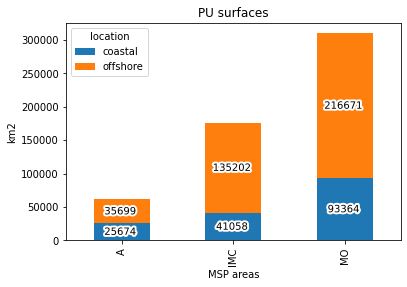

In [33]:
ax = pu_agg.reset_index().pivot(index="msp", columns="location", values='geoarea').plot.bar(stacked=True)
add_annotation(ax)
ax.set_xlabel('MSP areas')
ax.set_ylabel('km2')
ax.set_title("PU surfaces")
plt.show()

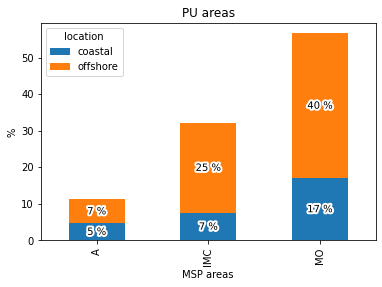

In [34]:
ax = pu_agg.reset_index().pivot(index="msp", columns="location", values='geoarea_perc').plot.bar(stacked=True)
add_annotation(ax, suffix="%")
ax.set_xlabel('MSP areas')
ax.set_ylabel('%')
ax.set_title("PU areas")
plt.show()

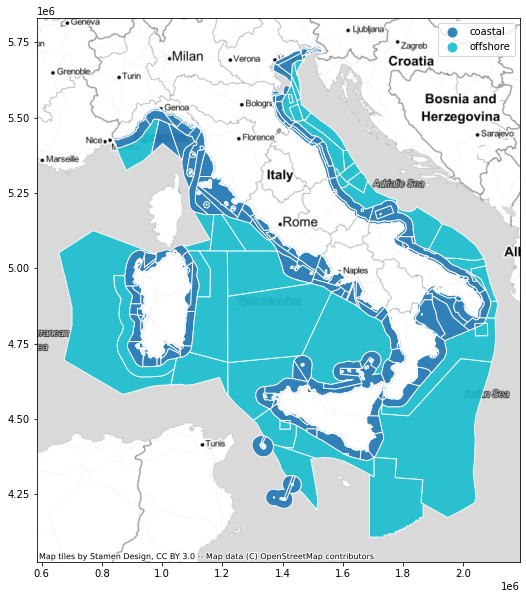

In [35]:
ax = planning_units.to_crs(epsg=3857).plot(column="location", 
                                           edgecolor='white',
                                           legend=True, figsize=[10, 10], alpha=0.9)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
plt.show()

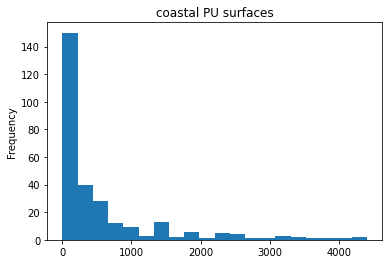

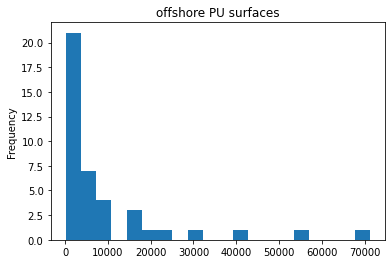

In [36]:
# ax = planning_units[[geoarea.plot.hist()
# ax.set_title('PU surface distribution')
# plt.show()
for l in ['coastal', 'offshore']:
    _df = planning_units[planning_units.location==l]
    ax = _df.geoarea.plot.hist(bins=20)
    ax.set_title('{} PU surfaces'.format(l))
    plt.show()

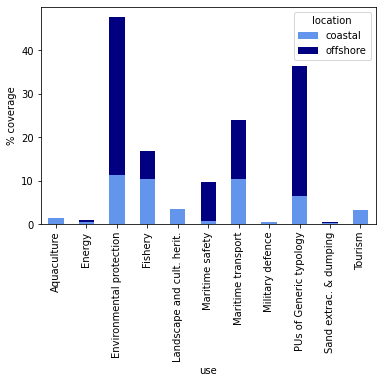

In [42]:
_df = df_main_uses.groupby(['use', 'location']).sum()
_df = _df.reset_index().pivot(index='use', values='geoarea_perc', columns='location')
ax = _df.plot.bar(stacked=True,
             color={"offshore": "navy", "coastal": "cornflowerblue"}
            )
ax.set_ylabel('% coverage')
plt.show()

## PUs type <a class="anchor" id=""></a>

In [37]:
pu_agg = planning_units.groupby(['msp','pu_type'])\
.agg(
    PUs=pd.NamedAgg(column="Code", aggfunc="count"),
    kmq=pd.NamedAgg(column="area_km", aggfunc="sum"),
    geoarea=pd.NamedAgg(column="geoarea", aggfunc="sum"),
    geoarea_perc=pd.NamedAgg(column="geoarea_perc", aggfunc="sum"),
    maxarea=pd.NamedAgg(column="geoarea", aggfunc="max"),
    minarea=pd.NamedAgg(column="geoarea", aggfunc="min"),
)

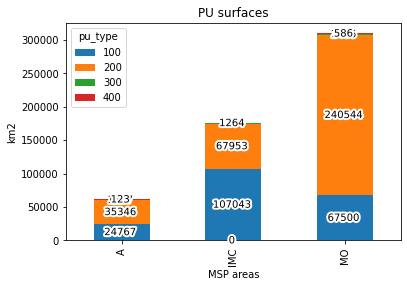

In [38]:
ax = pu_agg.reset_index().pivot(index="msp", columns="pu_type", values='geoarea').plot.bar(stacked=True)
add_annotation(ax)
ax.set_xlabel('MSP areas')
ax.set_ylabel('km2')
ax.set_title("PU surfaces")
plt.show()

## PUs main use <a class="anchor" id=""></a>

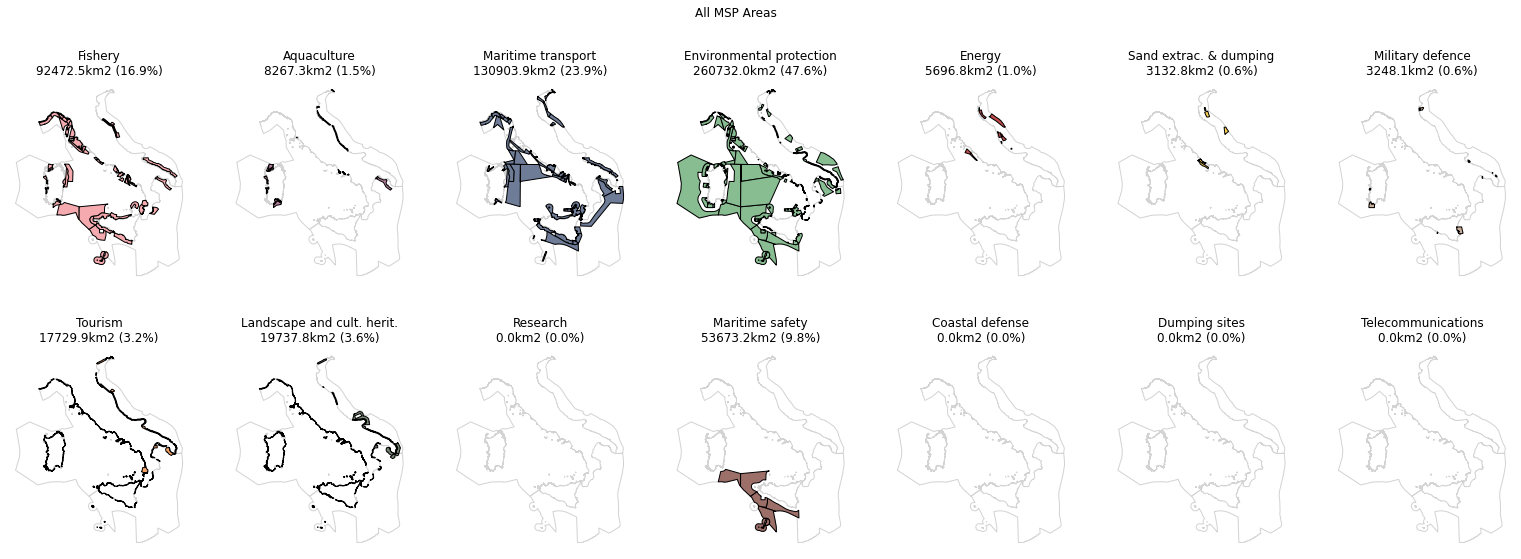

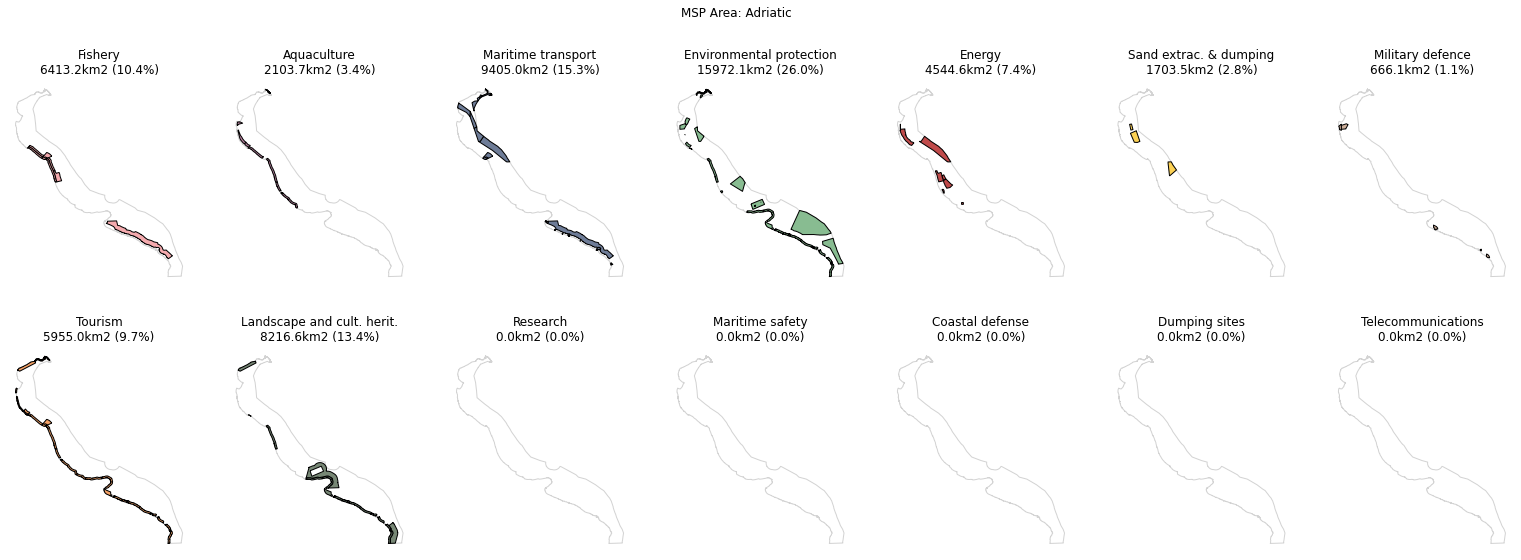

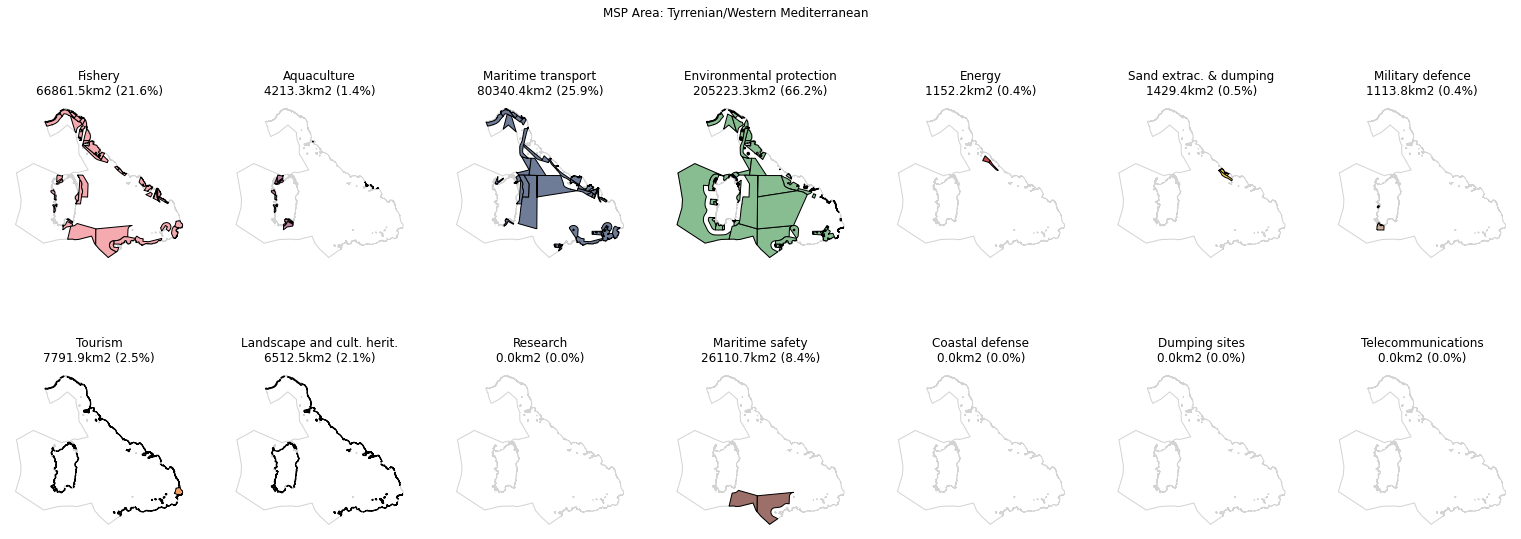

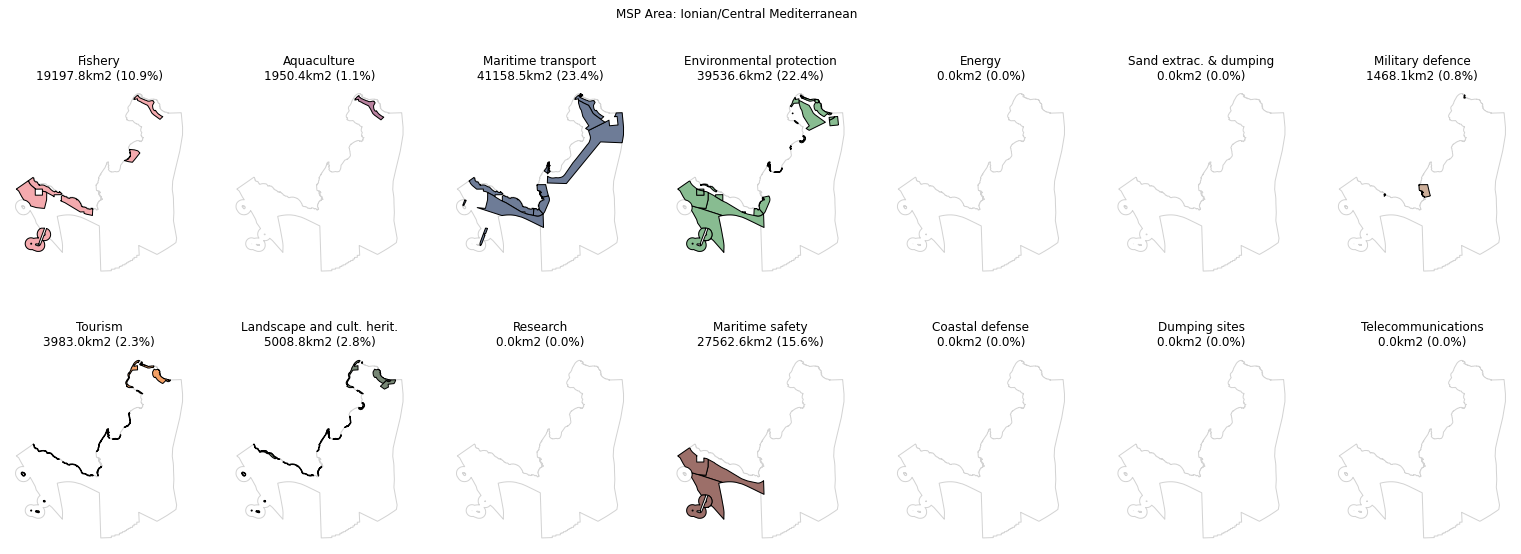

In [39]:
msps = [None, 'A', 'MO', 'IMC']
for m in msps:
    fig, axs = plt.subplots(2, 7, figsize=[27, 9])#, subplot_kw=dict(projection="polar"))
    i = 0
    if m is not None:
        _msp_areas = msp_areas[msp_areas['area']==m]
        df = planning_units[planning_units.msp==m]
        title = "MSP Area: {}".format(AREA_LABELS.get(m))
    else:
        _msp_areas = msp_areas.copy()
        df = planning_units.copy()
        title = "All MSP Areas"
    _totsurface = df.geoarea.sum()
    for _code, u in dfuses.iterrows():
        code = "{}".format(_code).zfill(4)
        label = u.use_eng_short
        color = u.color
        if color == '#':
            continue
        ax = axs.flatten()[i]
        _df = df[df.main_uses.str.contains(code).fillna(False)]
        _msp_areas.plot(ax=ax, edgecolor='lightgrey', color='None')
        if _df.shape[0] > 0:
            _df.plot(ax=ax, color=color, edgecolor='black')
        plot_label = "{}\n{}km2 ({}%)".format(label.capitalize(), _df.geoarea.sum().round(1), (_df.geoarea.sum()/_totsurface * 100).round(1))
        ax.set_title(plot_label)
        ax.set_axis_off()
        # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

        # print(code, label, _df.shape)
        i += 1
    plt.suptitle(title)
    plt.show()




# Multi-use analysis <a class="anchor" id=""></a>

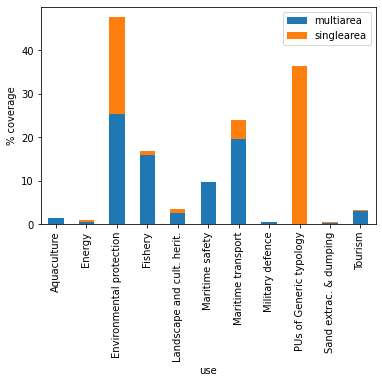

In [43]:
_df = df_main_uses.groupby('use').sum()
ax = _df[['multiarea', 'singlearea']].plot.bar(stacked=True)
ax.set_ylabel('% coverage')
plt.show()

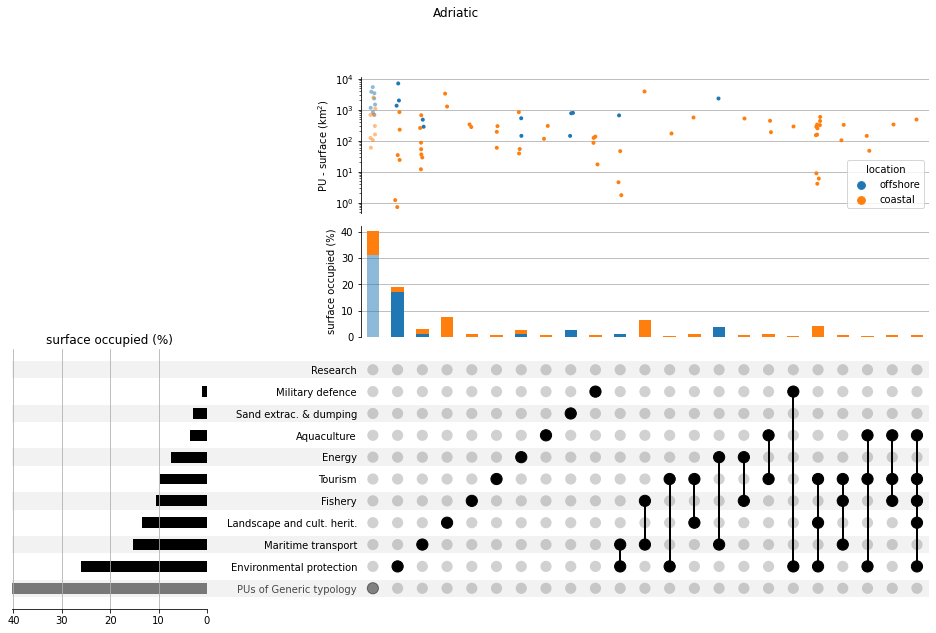

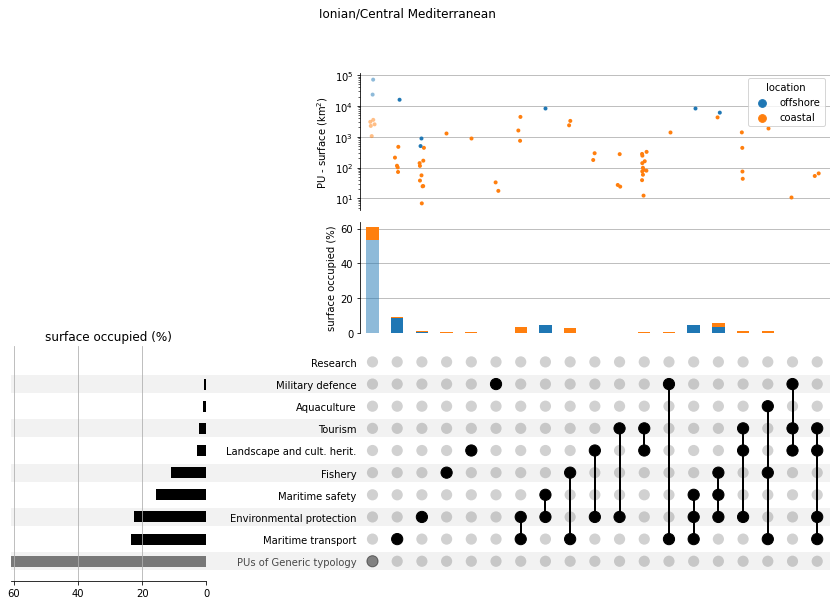

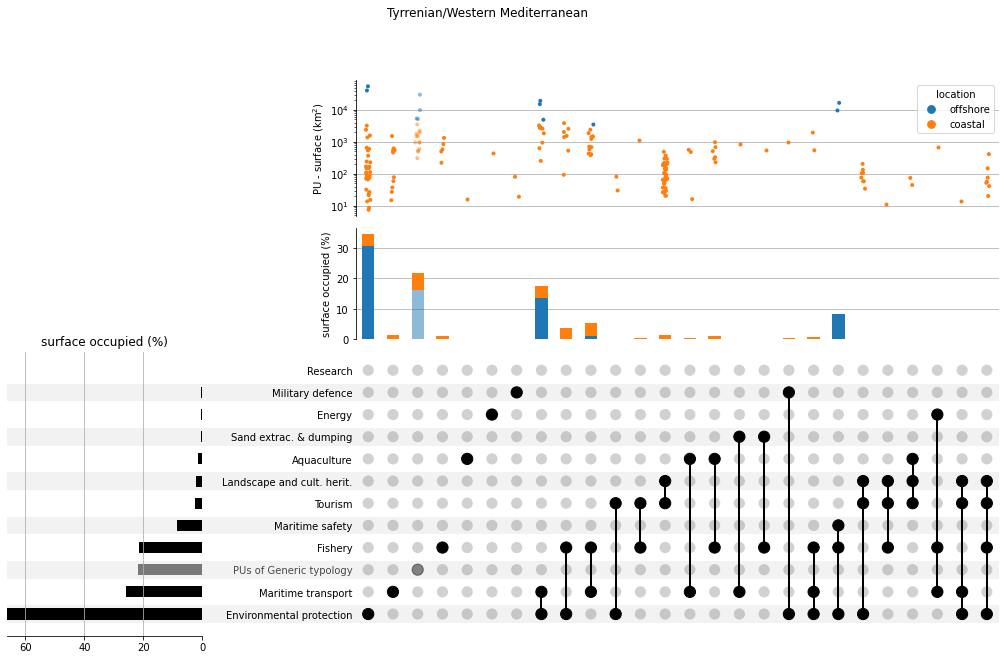

In [73]:

#for area in ['MO']:  
for area in ['A', 'IMC', 'MO']:

    _filter = planning_units.msp == area
    _df = planning_units[_filter].copy()
    # recalculate perc
    _df['geoarea_perc'] = _df['geoarea'] / _df.geoarea.sum() * 100
    # _filter = _df.main_uses.notnull()
    # _df = _df[_filter].copy()
    _df.main_uses_sorted_list_labels = _df.main_uses_sorted_list_labels.apply(lambda x: x if len(x)>0 else (glabel,))
    # _df = _df.groupby(['main_uses_sorted_list_labels', 'location'])[['geoarea', 'geoarea_perc']].sum().reset_index('location')
    # upset_data = from_memberships(_df.main_uses_sorted_list_codes,
    #                               data=_df[['geoarea', 'geoarea_perc', 'location']])
    upset_data = from_memberships(_df.main_uses_sorted_list_labels,
                                  data=_df[['geoarea', 'geoarea_perc', 'location']])
    
    # add research & innovation empty
    # upset_data['r'] = False
    # upset_data = upset_data.set_index('r', append=True)
    upset_data['Research'] = False
    upset_data = upset_data.set_index('Research', append=True)
    
    # upplot(upset_data)
    upset = UpSet(upset_data,
                  sum_over="geoarea_perc",
                  intersection_plot_elements=0,
                  totals_plot_elements=8,
                 #  show_counts='%d%%',
                  # show_percentages=True,
                 )  # disable the default bar chart
    if glabel in upset_data.index.names:
        upset.style_subsets(present=glabel, facecolor="#00000077")
    bars = upset.add_stacked_bars(by="location", 
                           #colors=cm.Pastel1,
                           # title="% of combination of uses \nover the MSP area surface", 
                           # title="combination of uses\nsurface (%)", 
                           # title = "share of the total MA\nsurface occupied (%)",
                           title = "surface occupied (%)",
                           sum_over="geoarea_perc",
                           elements=5)
    upset.add_catplot(value='geoarea',
                      kind='strip', 
                      elements=6, hue='location', size=4, hue_order=['offshore', 'coastal'])
    plots = upset.plot()
    # plots['extra0'].set(yscale="log")
    # plots['extra0'].set(ylabel="area (km2)")
    # plots['totals'].set_title("% of use\nover the MSP area surface")
    # plots['totals'].set_title("use - surface (%)")
    plots['totals'].set_title("surface occupied (%)")
    plots['extra0'].get_legend().remove()
    plots['extra1'].set(ylabel="PU - surface (km$^2$)")
    plots['extra1'].set(yscale="log")
    # add alpha to generic PU
    glabel_index = None
    for i, t in enumerate(plots['matrix'].get_yticklabels()):
        if t.get_text() == glabel:
            t.set_alpha(0.7)
            glabel_index = i
    plots['totals'].get_children()[glabel_index].set_alpha(0.5)
    plots['extra0'].get_children()[glabel_index].set_alpha(0.5)
    plots['extra1'].get_children()[glabel_index].set_alpha(0.5)
    #     plots['matrix'].get_yticklabels()[2].set_alpha(0.7)

    plots['matrix'].figure.suptitle(AREA_LABELS.get(area))
    # plots['matrix'].figure.subplots_adjust(top=0.93) # adjust the Figure in rp
    # plots['matrix'].figure.suptitle("Coexistence analysis - Vocational uses: {} MSP area".format(AREA_LABELS.get(area)))
    plt.savefig("exploratory_outputs/multiuse_{}.svg".format(area))
    plt.savefig("exploratory_outputs/multiuse_{}.png".format(area), dpi=300)
    _df[['Code', 'Type', 'main_uses_sorted_list_labels', 'geoarea', 'geoarea_perc']].to_html("exploratory_outputs/multiuse_{}.html".format(area))
    plt.show()